# Data Scientist Professional Practical Exam Submission

**Use this template to write up your summary for submission. Code in Python or R needs to be included.**


## 📝 Task List

Your written report should include both code, output and written text summaries of the following:
- Data Validation:   
  - Describe validation and cleaning steps for every column in the data 
- Exploratory Analysis:  
  - Include two different graphics showing single variables only to demonstrate the characteristics of data  
  - Include at least one graphic showing two or more variables to represent the relationship between features
  - Describe your findings
- Model Development
  - Include your reasons for selecting the models you use as well as a statement of the problem type
  - Code to fit the baseline and comparison models
- Model Evaluation
  - Describe the performance of the two models based on an appropriate metric
- Business Metrics
  - Define a way to compare your model performance to the business
  - Describe how your models perform using this approach
- Final summary including recommendations that the business should undertake

*Start writing report here..*

# 1 Data Validation:   
  - Describe validation and cleaning steps for every column in the data 

Data is imported, and some basic data validations have been performed. There are 52 missing values in few columns of the dataset, including how many rows contains 'null' values. 

Feature and target variables are cleaned as necessary. For instance, category column contains 'Chicken' & 'Chiken Breast', both should belong to same category 'Chicken'. 

In [1]:
# Start coding here...
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# from scipy.stats import boxcox, yeojohnson
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, PowerTransformer, MinMaxScaler
from scipy.stats.mstats import winsorize
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.tree import export_graphviz
import graphviz
from sklearn.tree import plot_tree

In [2]:
data = pd.read_csv('recipe_site_traffic_2212.csv')
data.head()

,recipe,calories,carbohydrate,sugar,protein,category,servings,high_traffic
0,1,NaN,NaN,NaN,NaN,Pork,6,High
1,2,35.48,38.56,0.66,0.92,Potato,4,High
2,3,914.28,42.68,3.09,2.88,Breakfast,1,NaN
3,4,97.03,30.56,38.63,0.02,Beverages,4,High
4,5,27.05,1.85,0.80,0.53,Beverages,4,NaN


In [3]:
# data.info()
# display(data.isna().sum())

In [4]:
# Feature variables: category & high_traffic 
data['category'] = data['category'].str.replace(' Breast','')
# display(data['category'].value_counts())

# high_traffic
# display(data['high_traffic'].value_counts())
data['high_traffic'] = np.where(data['high_traffic'] == "High", 1, 0)

# Check duplicate values
data.duplicated(subset='recipe').sum()  # no duplicates

0

In [5]:
# Target variables
# Clean 'servings' column
data['servings'].value_counts()
data['servings'] = data['servings'].str.replace(" as a snack", "")
data['servings'].value_counts()
# since 'serving' is a target variable, lets convert it to integer
data['servings'] = data['servings'].astype('int')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 947 entries, 0 to 946
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   recipe        947 non-null    int64  
 1   calories      895 non-null    float64
 2   carbohydrate  895 non-null    float64
 3   sugar         895 non-null    float64
 4   protein       895 non-null    float64
 5   category      947 non-null    object 
 6   servings      947 non-null    int64  
 7   high_traffic  947 non-null    int64  
dtypes: float64(4), int64(3), object(1)
memory usage: 59.3+ KB


In [6]:
# Drop rows with missing values
data = data.dropna().reset_index(drop=True)
data.isna().sum()


recipe          0
calories        0
carbohydrate    0
sugar           0
protein         0
category        0
servings        0
high_traffic    0
dtype: int64

In [7]:
data.columns

Index(['recipe', 'calories', 'carbohydrate', 'sugar', 'protein', 'category',
       'servings', 'high_traffic'],
      dtype='object')

# 2 Exploratory Analysis:  
  - 2.1 Include two different graphics showing single variables only to demonstrate the characteristics of data  
  - 2.2 Include at least one graphic showing two or more variables to represent the relationship between features
  - 2.3 Describe your findings

**2.1** Let's check if we have imbalanced dataset. We will find answer by ploting bar graph of target variable. We have a balanced dataset since there is no dramatically disproportion in two categories in target variable, as shown in below barplot. We may needed to be careful selecting performance metric if we had imbalanced dataset.

Additionally, which reciple is most popular? Chicken is most popular item followed by Breakfast

<AxesSubplot: >

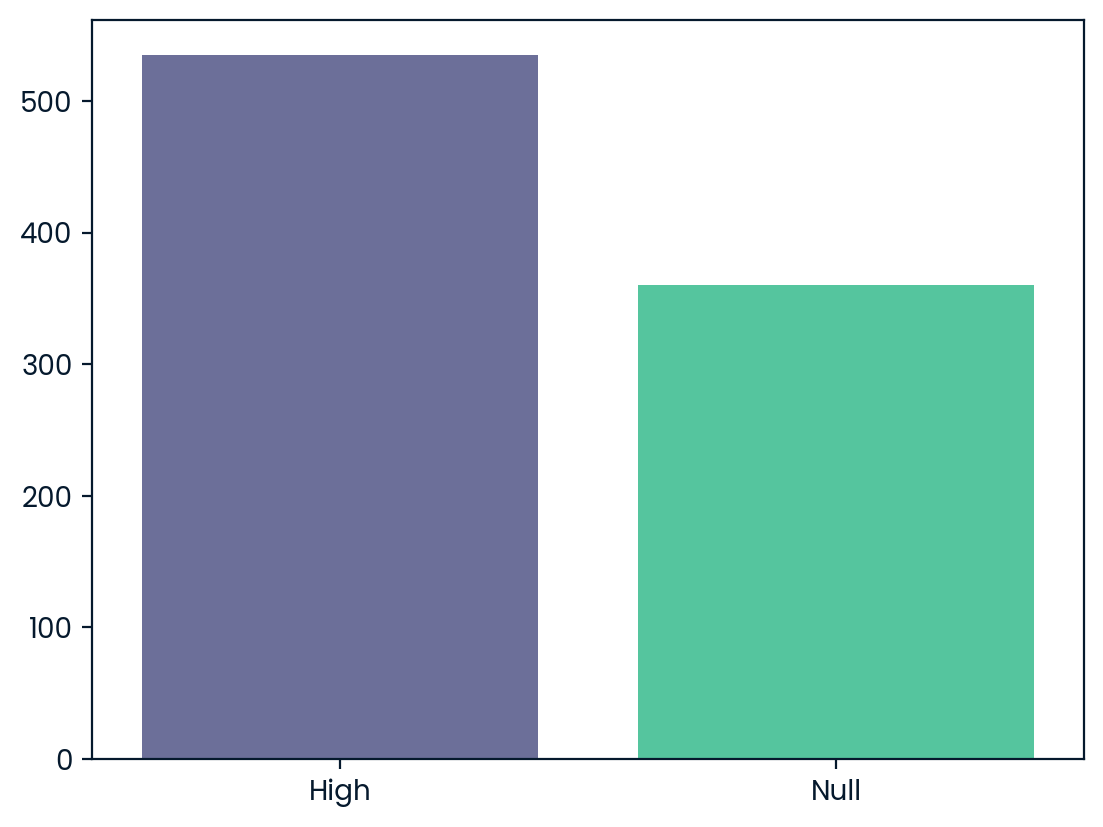

In [8]:
# data.plot.hist(column='high_traffic')
high_traffic = pd.DataFrame(data['high_traffic'].value_counts())
high_traffic2 = pd.DataFrame(data={'High': [535], 'Null': [360]})
sns.barplot(high_traffic2)
# print(data['high_traffic'].value_counts(False))

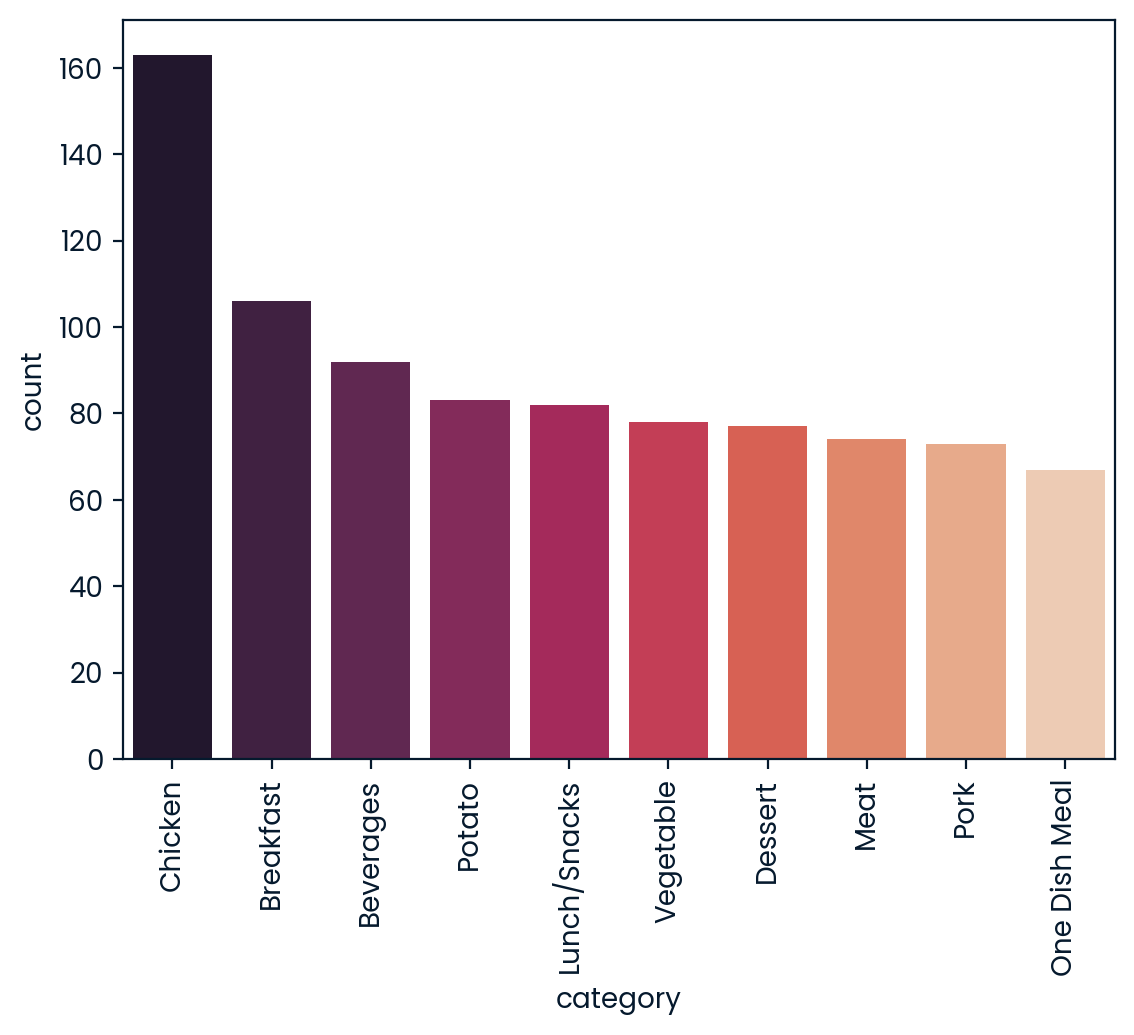

In [9]:
sns.countplot(data, x="category",
             order = data['category'].value_counts().index,
             palette='rocket'
             )
plt.xticks(rotation=90)
plt.show()

**2.2** Multiple variables are analysed here. Let's examine if any feature variable is correlated to target variable. It should be noted that due to the nature of our problem, **'high_traffic' is our target variable.** No feature is strongly correlated to the target variable, which is observed from two colors (for True and False of High_traffic). Additionally, there is NO multicolearity in the data (no features are correlated to each other). 

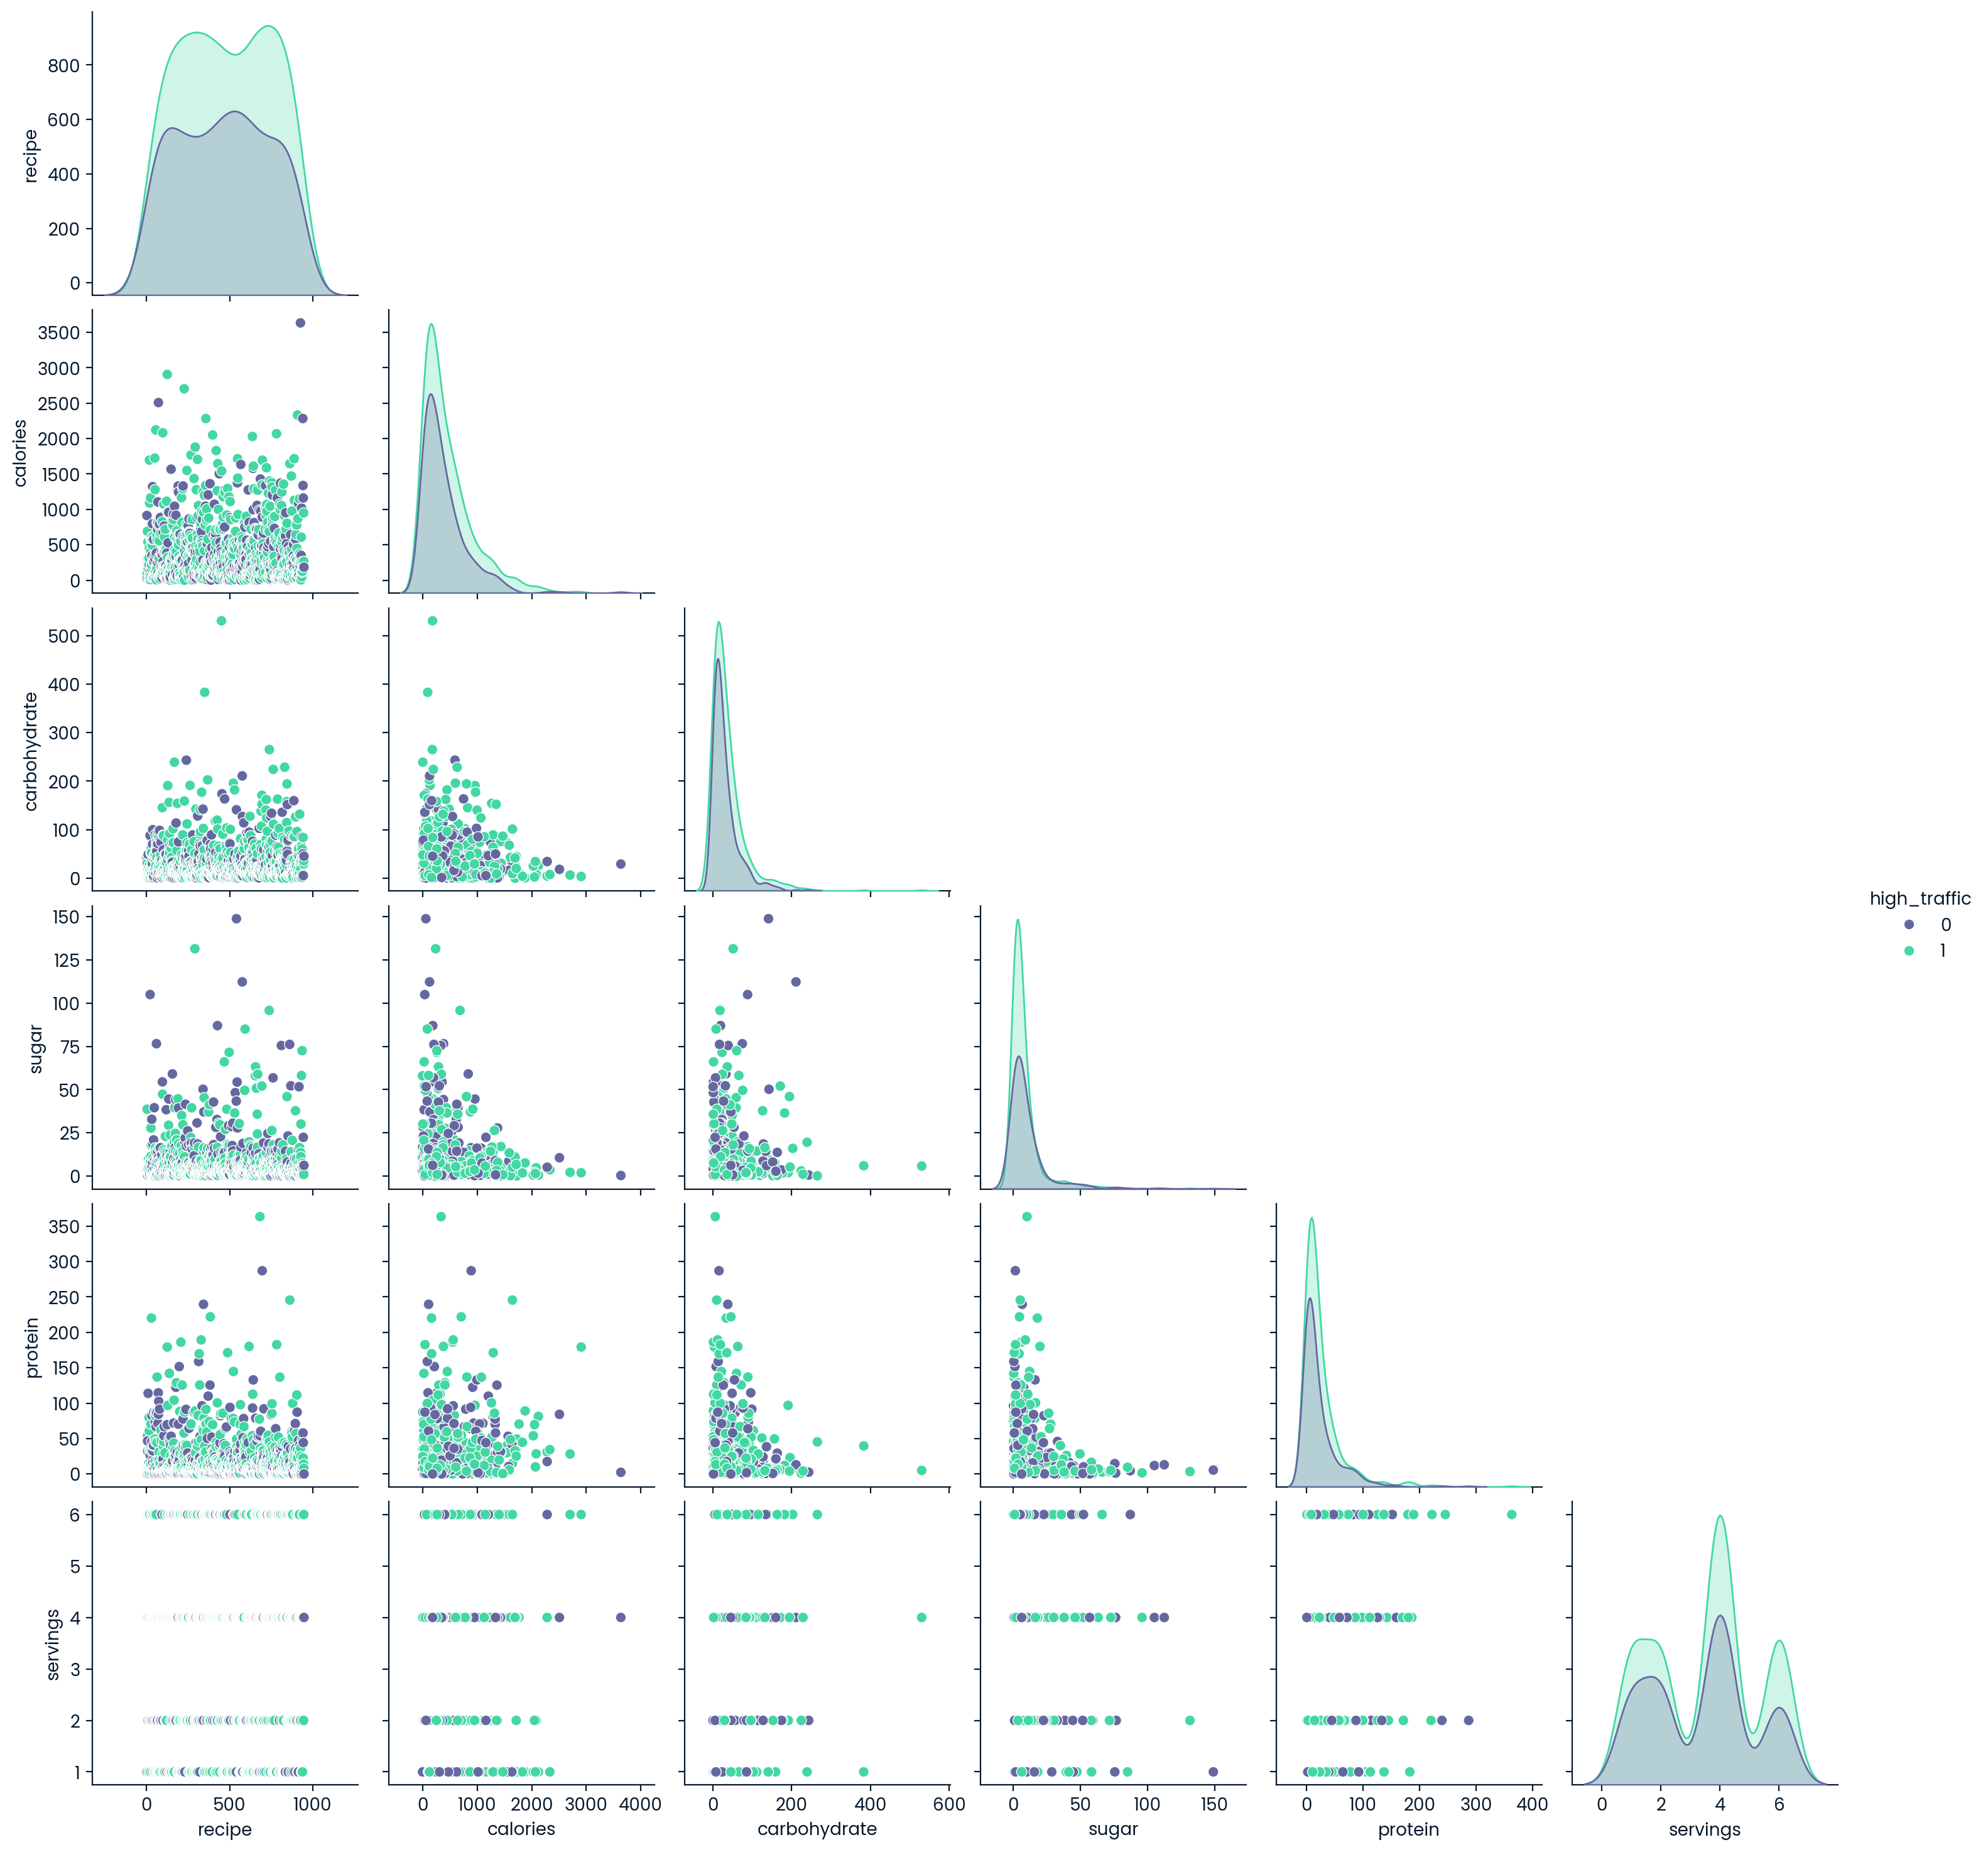

In [10]:
pairplot = sns.pairplot(data[['recipe', 'calories', 'carbohydrate', 'sugar', 'protein', 'category',
       'servings', 'high_traffic']], hue='high_traffic')
# Apply a mask to hide the upper triangle
for i, j in zip(*np.triu_indices_from(pairplot.axes, 1)):
    pairplot.axes[i, j].set_visible(False)
plt.show()

**2.3:**
Since its a small dataset containing only 947 records and 7 columns only, modeling will be simpler for such binary classification problem.

# 3 Model Development
  - Include your reasons for selecting the models you use as well as a statement of the problem type
  - Code to fit the baseline and comparison models

We are aiming to determine "whether there is a high traffic". Since we are dealing with "whether", meaning yes/no situation, the problem is a binary classification problem. 

Therefore, Logistic regression can be takes as a baseline model (a common practise in the industry for interpretibility of such model, and less amount of resource needed to train and run the model). After observing the performance of Logistic Regression, a Random Forest (RF) classifier is also considered. RF is an ensemble method that builds multiple decision trees and merges them to get a more accurate and stable prediction.

In [11]:
# data prep for modeling
data_prep = data.copy()
labelencoder = LabelEncoder()
data_prep['category'] = labelencoder.fit_transform(data_prep['category'])
numeric_cols = ['calories', 'carbohydrate', 'sugar', 'protein', 'servings'] 
X = data_prep[numeric_cols + ['category']] # Features
y = data_prep['high_traffic'] # Target variable

# Normalize the numeric features
scaler = StandardScaler()
X[numeric_cols] = scaler.fit_transform(X[numeric_cols])

#split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.columns

Index(['calories', 'carbohydrate', 'sugar', 'protein', 'servings', 'category'], dtype='object')

In [12]:
# Build Logistic Regression
model_LR = LogisticRegression()
model_LR.fit(X_train, y_train)

# Prediction
y_pred_LR = model_LR.predict(X_train)
y_pred_t_LR = model_LR.predict(X_test)

# 4 Model Evaluation
  - Describe the performance of the two models based on an appropriate metric

Since we are not dealing with imbalanced dataset, accuracy and confusion matrix suffice to evaluate model's performance.

Logistic Regression
Training metrics: Accuracy= 0.755586592178771
Confusion Table 
 [[210  77]
 [ 98 331]]
Testing metrics: Accuracy= 0.770949720670391
Confusion Table 
 [[51 22]
 [19 87]]


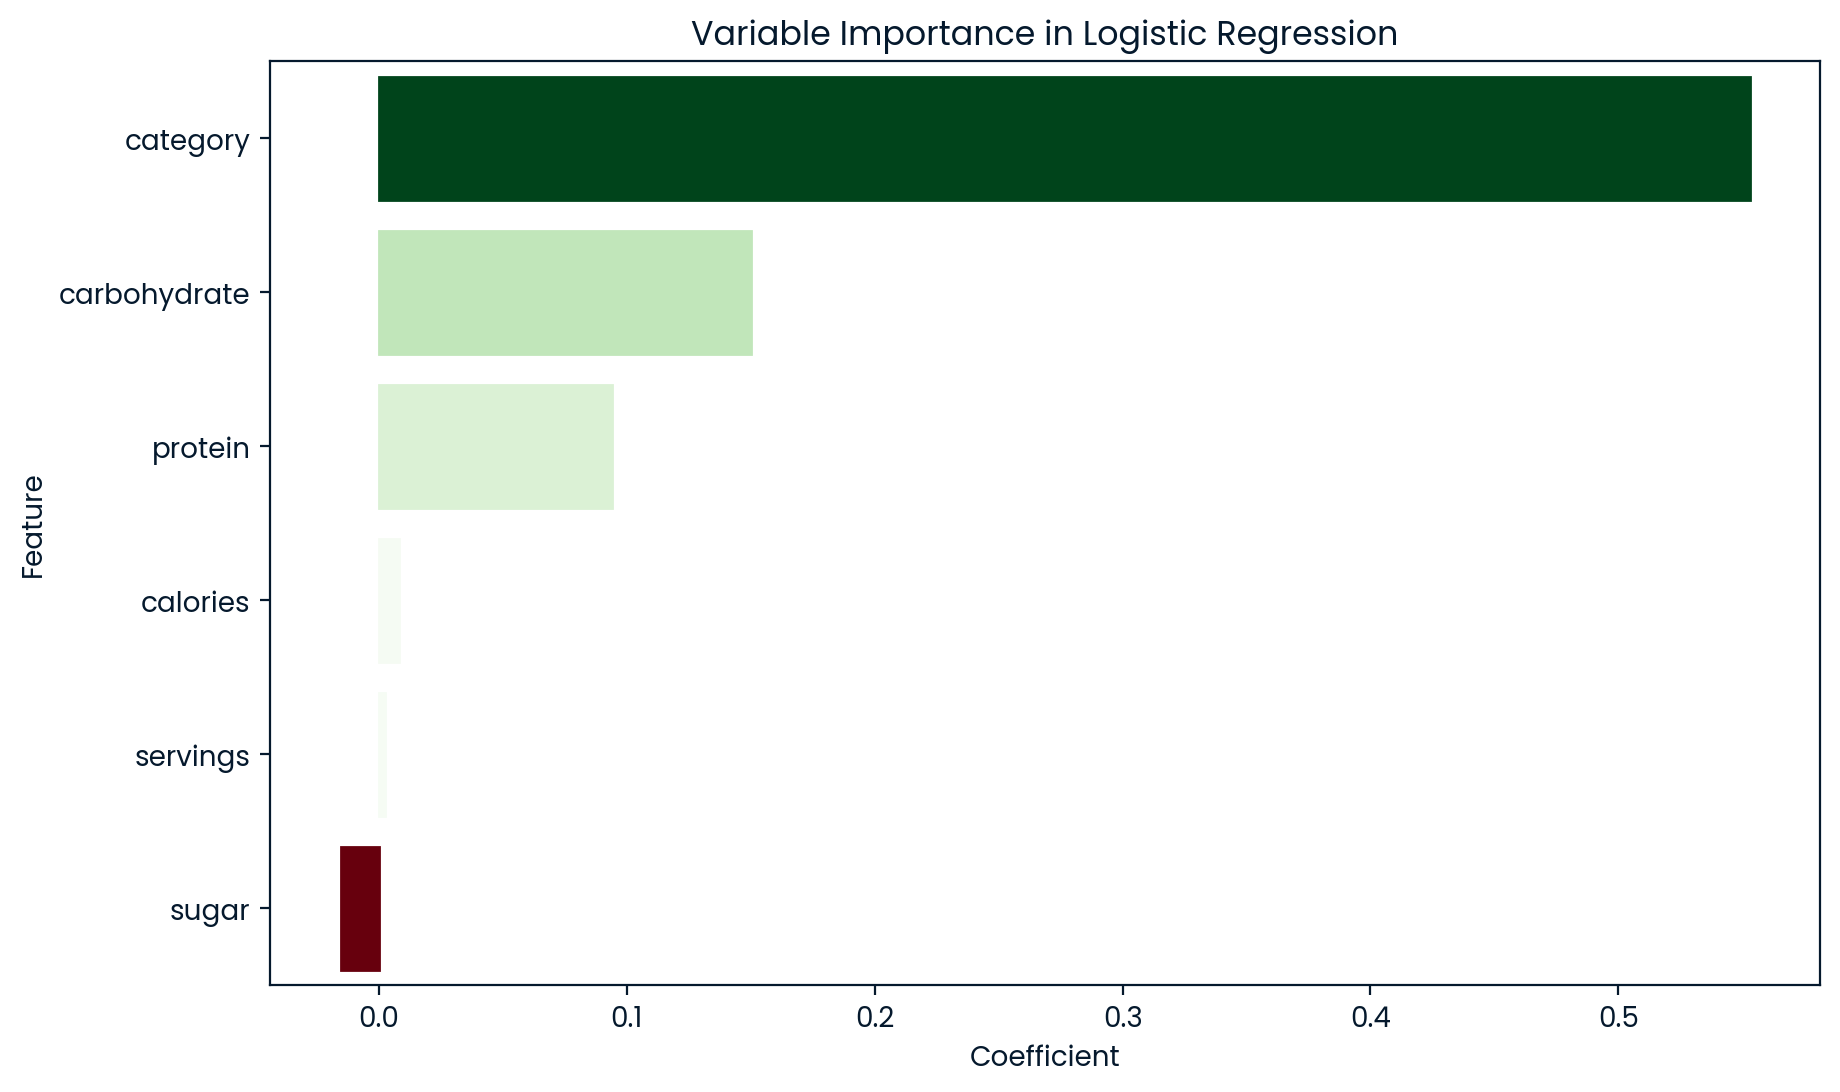

In [13]:
# Training metrics
accuracy_LR = metrics.accuracy_score(y_train, y_pred_LR)
cm_LR = metrics.confusion_matrix(y_train, y_pred_LR)
# Testing metrics
test_accuracy_LR = metrics.accuracy_score(y_test, y_pred_t_LR)
test_cm_LR = metrics.confusion_matrix(y_test, y_pred_t_LR)
print('Logistic Regression')
print('Training metrics: Accuracy=', accuracy_LR)
print('Confusion Table \n', cm_LR)
print('Testing metrics: Accuracy=', test_accuracy_LR)
print('Confusion Table \n', test_cm_LR)


# Extract feature coefficients
coefficients = model_LR.coef_[0]
# Create a dataframe for plotting
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': coefficients
})
importance_df = importance_df.sort_values(by='Coefficient', ascending=False)
# Plot
plt.figure(figsize=(10, 6))
# Apply colors based on positive or negative coefficient values
colors = ['red' if c < 0 else 'black' for c in importance_df['Coefficient']]
sns.barplot(x='Coefficient', y='Feature', data=importance_df, orient='h', palette=colors)

# Apply gradient colors for positive values
for i, (coeff_trans, color) in enumerate(zip(importance_df['Coefficient'], colors)):
    if coeff_trans >= 0:
        plt.gca().patches[i].set_color(plt.cm.Greens(coeff_trans / max(importance_df['Coefficient'])))
    else:
        plt.gca().patches[i].set_color(plt.cm.Reds(coeff_trans / min(importance_df['Coefficient'])))

        
plt.title('Variable Importance in Logistic Regression')
plt.show()

In [14]:
# Build Random Forest 
model_RF = RandomForestClassifier()
model_RF.fit(X_train, y_train)

# Prediction
y_pred_RF = model_RF.predict(X_train)
y_pred_t_RF = model_RF.predict(X_test)

# 
# Training metrics
accuracy_RF = metrics.accuracy_score(y_train, y_pred_RF)
cm_RF = metrics.confusion_matrix(y_train, y_pred_RF)
# Testing metrics
test_accuracy_RF = metrics.accuracy_score(y_test, y_pred_t_RF)
test_cm_RF = metrics.confusion_matrix(y_test, y_pred_t_RF)
print('Random Forest')
print('Training metrics: Accuracy=', accuracy_RF)
print('Confusion Table \n', cm_RF)
print('Testing metrics: Accuracy=', test_accuracy_RF)
print('Confusion Table \n', test_cm_RF)

Random Forest
Training metrics: Accuracy= 1.0
Confusion Table 
 [[287   0]
 [  0 429]]
Testing metrics: Accuracy= 0.7094972067039106
Confusion Table 
 [[42 31]
 [21 85]]


In [15]:
# Hyperparameter tuning for RF (final performance didnt improve much)
param_grid = {
    'n_estimators': [500, 200], #300, 400,  
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [None, 10,  50], # 20, 30, 40,
    'min_samples_split': [2, 10]
    #'min_samples_leaf': [1, 2, 4],
    #'bootstrap': [True, False]
}
rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=2, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
best_rf = grid_search.best_estimator_

y_pred = best_rf.predict(X_test)
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
print("Classification Report:\n", metrics.classification_report(y_test, y_pred))


Fitting 2 folds for each of 36 candidates, totalling 72 fits
Best Parameters: {'max_depth': 10, 'max_features': 'auto', 'min_samples_split': 10, 'n_estimators': 200}
Accuracy: 0.7262569832402235
Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.58      0.63        73
           1       0.74      0.83      0.78       106

    accuracy                           0.73       179
   macro avg       0.72      0.70      0.71       179
weighted avg       0.72      0.73      0.72       179



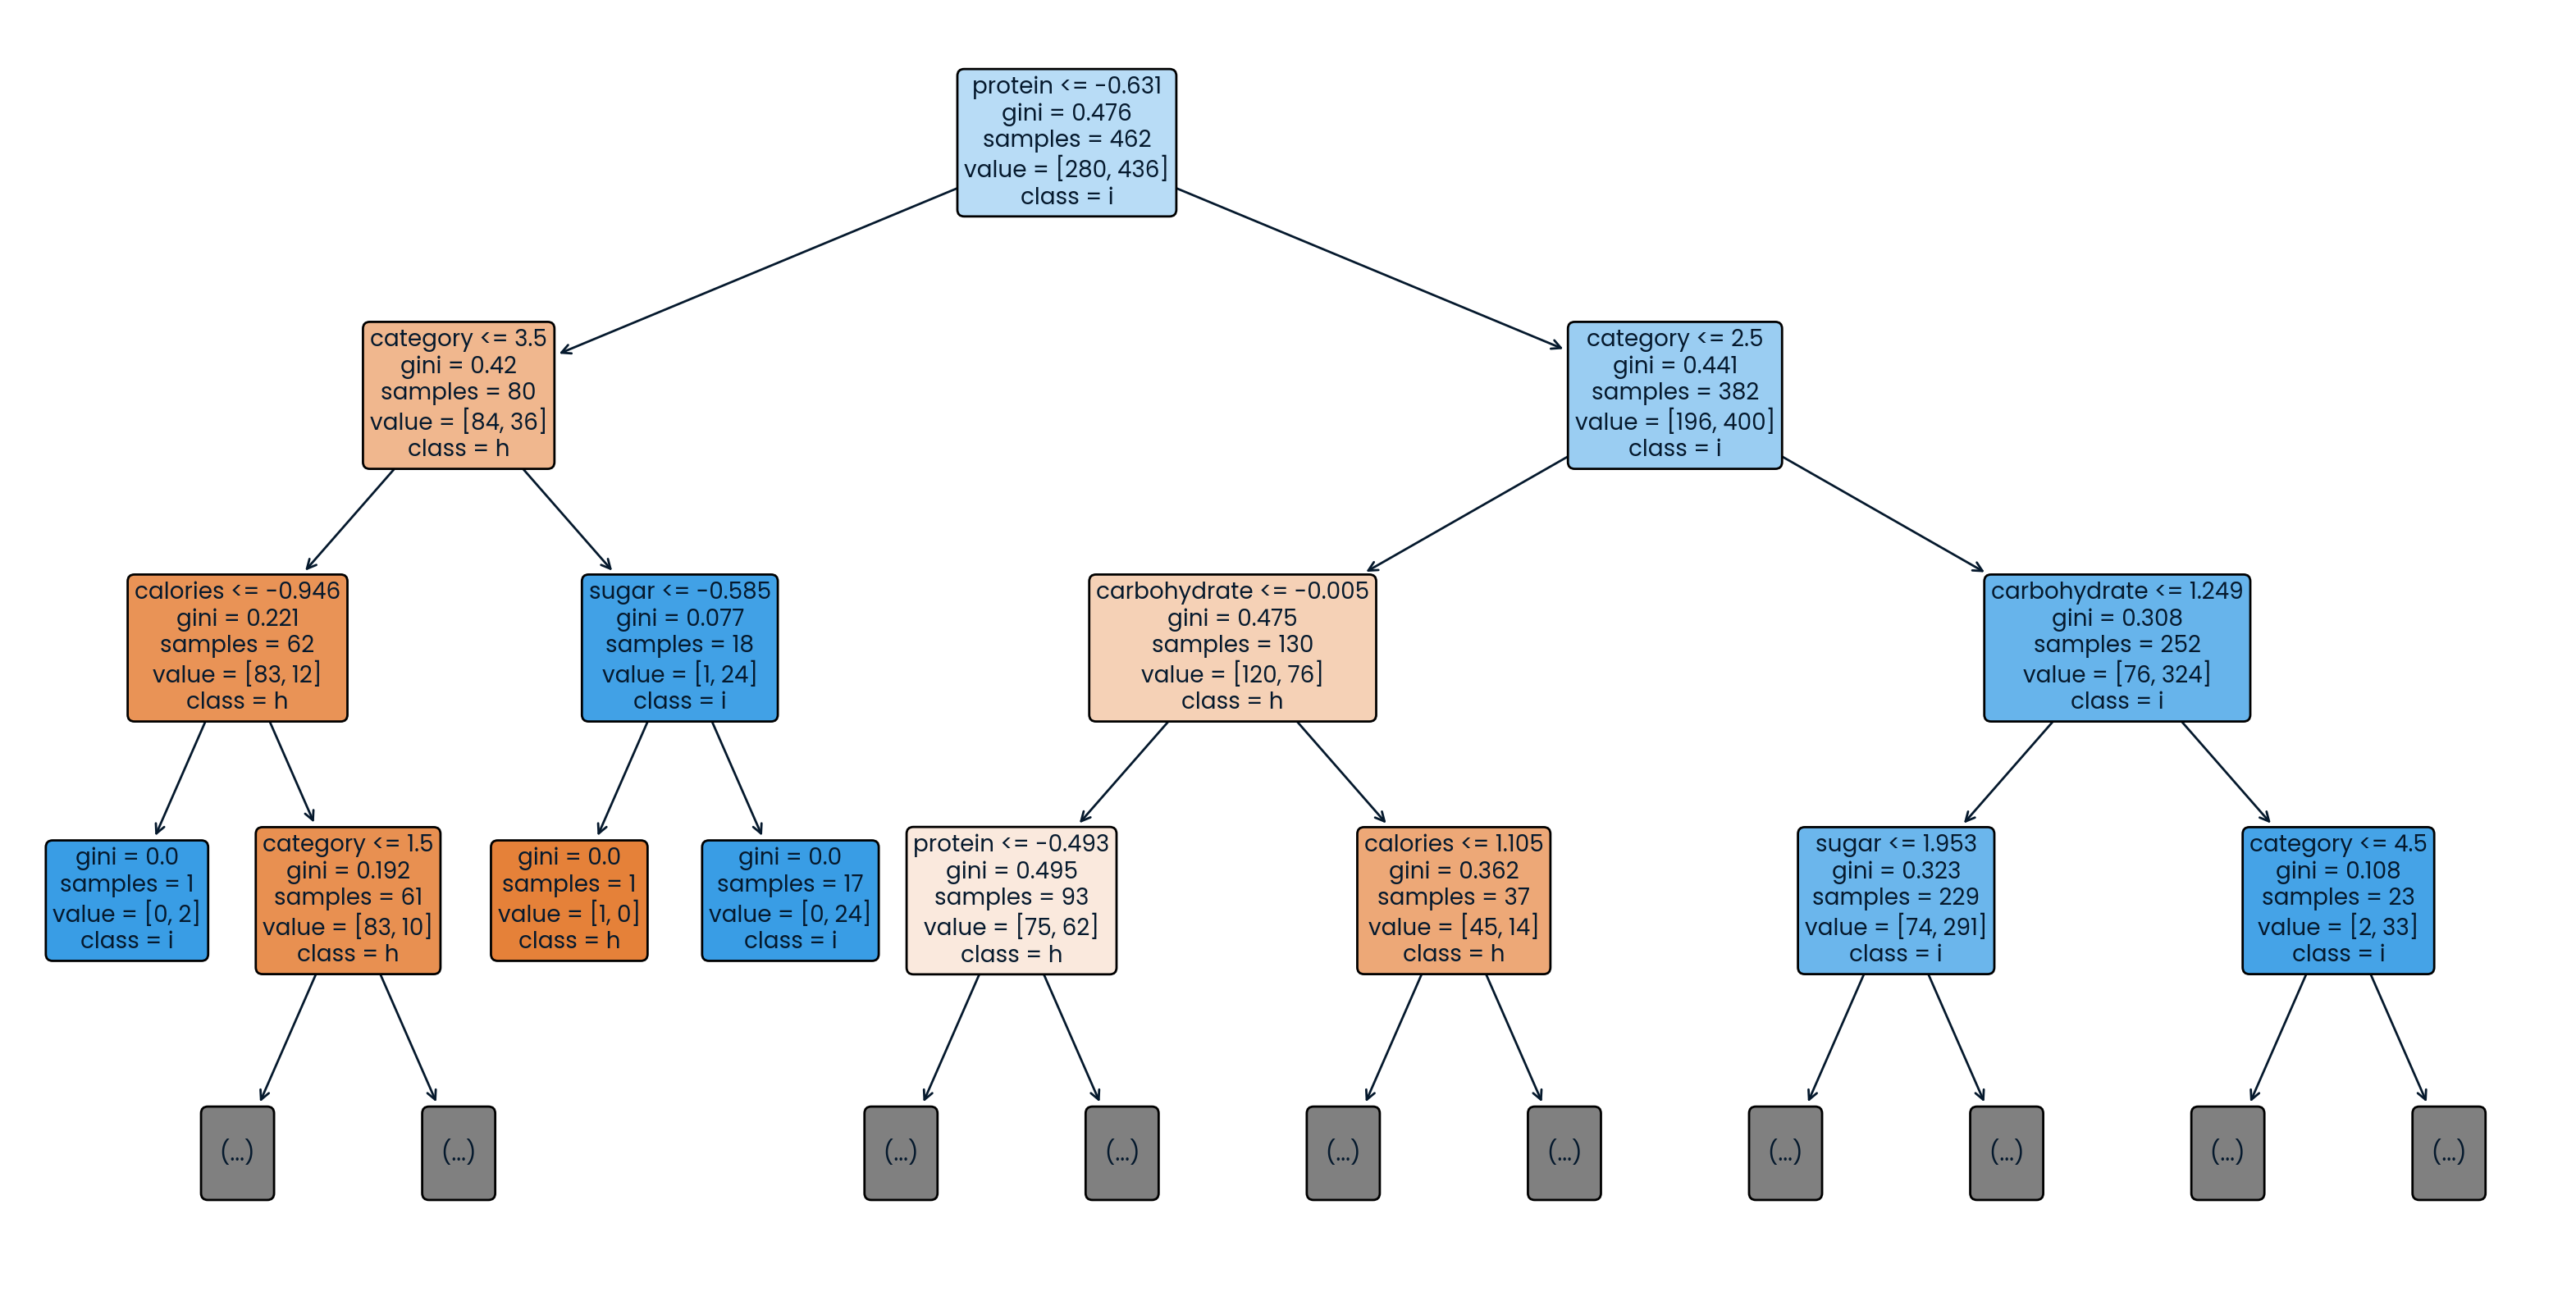

In [16]:

# Extract one of the trees
tree = model_RF.estimators_[0]

"""
# Export the tree to Graphviz format
dot_data = export_graphviz(
    tree, 
    out_file=None, 
    feature_names=['calories', 'carbohydrate', 'sugar', 'protein', 'servings', 'category'],
    class_names='high_traffic', 
    filled=True, 
    rounded=True, 
    special_characters=True
)

# Visualize the tree using Graphviz
graph = graphviz.Source(dot_data)
graph.render("random_forest_tree", format='png', cleanup=True)  # Save the tree as a PNG file
graph.view()  # Open the PNG file
"""

plt.figure(figsize=(20, 10))
plot_tree(tree, 
          max_depth=3, 
          feature_names=['calories', 'carbohydrate', 'sugar', 'protein', 'servings', 'category'],
          class_names='high_traffic', 
          filled=True, 
          rounded=True, 
          fontsize=10)
plt.show()


# 5 Business Metrics
  - Define a way to compare your model performance to the business
  - Describe how your models perform using this approach

To compare the performance of a Logistic Regression (LR) model and a Random Forest (RF) model, we first trained both models on the same dataset and evaluate them using accuracy and a confusion matrix. **Accuracy** measures the proportion of correctly predicted instances out of the total instances. The **confusion matrix** provides detailed insights by showing the number of true positives, true negatives, false positives, and false negatives. 

After evaluating both models, we found that the LR model has higher accuracy, indicating it correctly predicts more instances overall compared to RF. The confusion matrix shows fewer false negatives and false positives for the LR model, suggesting it is better at distinguishing between the two classes (high traffic or not) . This implies that for this particular application, the LR model is more reliable in predicting customer preferences for recipes.

# 6 Final summary 

Logistic Regression performs better for our given test dataset (77% accurate compared to 70% by RF). Hence, logistic regression can be selected for future classification/ recommendation of recipe with high traffic.